# Projet de reconnaissance de panneaux routiers

## Importation des librairies

Voici les librairies que nous utilisons dans le projet.

In [3]:
# LIBRAIRIES DE TORCH
import torch as torch
from torch.utils import data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam, SGD
import torch.nn.functional as F

# LIBRAIRIES DE TRAITEMENT DE DONNEES
import numpy as np
import pandas as pd

# LIBRAIRIE DE TRAITEMENT D'IMAGES
from PIL import Image

# LIBRAIRIE DE PLOT
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150

## Importation des données

Pour commencer, nous aurons besoin d'un dictionnaire avec la signification de chaque label

In [4]:
CLASSES = { 
    0:"Limitation de vitesse (20km/h)",
    1:"Limitation de vitesse (30km/h)", 
    2:"Limitation de vitesse (50km/h)", 
    3:"Limitation de vitesse (60km/h)", 
    4:"Limitation de vitesse (70km/h)", 
    5:"Limitation de vitesse (80km/h)", 
    6:"Fin de limitation de vitesse (80km/h)", 
    7:"Limitation de vitesse (100km/h)", 
    8:"Limitation de vitesse (120km/h)", 
    9:"Interdiction de depasser", 
    10:"Interdiction de depasser pour vehicules > 3.5t", 
    11:"Intersection ou' vous etes prioritaire", 
    12:"Route prioritaire", 
    13:"Ceder le passage", 
    14:"Arret a' l'intersection", 
    15:"Circulation interdite", 
    16:"Acces interdit aux vehicules > 3.5t", 
    17:"Sens interdit", 
    18:"Danger", 
    19:"Virage a' gauche", 
    20:"Virage a' droite", 
    21:"Succession de virages", 
    22:"Cassis ou dos-d'ane", 
    23:"Chaussee glissante", 
    24:"Chaussee retrecie par la droite", 
    25:"Travaux en cours", 
    26:"Annonce feux", 
    27:"Passage pietons", 
    28:"Endroit frequente' par les enfants", 
    29:"Debouche' de cyclistes", 
    30:"Neige ou glace",
    31:"Passage d'animaux sauvages", 
    32:"Fin des interdictions precedemment signalees", 
    33:"Direction obligatoire a' la prochaine intersection : a' droite", 
    34:"Direction obligatoire a' la prochaine intersection : a' gauche", 
    35:"Direction obligatoire a' la prochaine intersection : tout droit", 
    36:"Direction obligatoire a' la prochaine intersection : tout droit ou a' droite", 
    37:"Direction obligatoire a' la prochaine intersection : tout droit ou a' gauche", 
    38:"Contournement obligatoire de l'obstacle par la droite", 
    39:"Contournement obligatoire de l'obstacle par la gauche", 
    40:"Carrefour giratoire", 
    41:"Fin d'interdiction de depasser", 
    42:"Fin d'interdiction de depasser pour vehicules > 3.5t" 
}


Ensuite nous pouvons commencer l'importation des données

### Le training et validation datasets

In [5]:
# on commence par recolter les donnees et transformer les images en tensors
raw_data = datasets.ImageFolder("panneaux_route/Train", transform=transforms.Compose(
    [transforms.Resize((32,32)),
    transforms.ToTensor()]
))

# nous souhaitons repartir les donnees entre le training et le validation dataset
training_size = int(0.85 * len(raw_data))
validation_size = len(raw_data) - training_size

# construisons les datasets
train_dataset, validation_dataset = data.random_split(raw_data, [training_size, validation_size])

# construisons les dataloader
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1024, shuffle=True)

### Les données de Test

Puisque les données de Test ne sont pas stockées comme les données du training, il faut aller les chercher dans le csv. Pour se faire, nous utilisons la librairie pandas. La librairie nous permet d'isoler les informations des classes et du chemin des différentes images.

In [6]:
df = pd.read_csv('panneaux_route/Test.csv', sep=',')
transformation = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])

labels = list(df['ClassId'])
images = list(df['Path'])
img_lst = []

for img in images :
    img = "panneaux_route/" + img
    img_lst.append(transformation(Image.open(img)))

Avec ces données, il va falloir les transférer dans un dataset personnalisé.

In [7]:
class MyDataSet(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

Et pour finir nous devons aussi faire notre dataloader du test

In [8]:
# le dataset
test_dataset = MyDataSet(img_lst, labels)

# le dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256)

## Explorons les données

Explorons un peu les données pour savoir ce que l'on manipule

In [9]:
print(raw_data.classes)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


Comme nous pouvons le voir au-dessus, les classes qui sont répertoriées dans nos raw_data ne sont pas dans le bon ordre. Pour pallier à ce problème, nous essayerons de changer le retour des fonctions de validations et d'affichage.

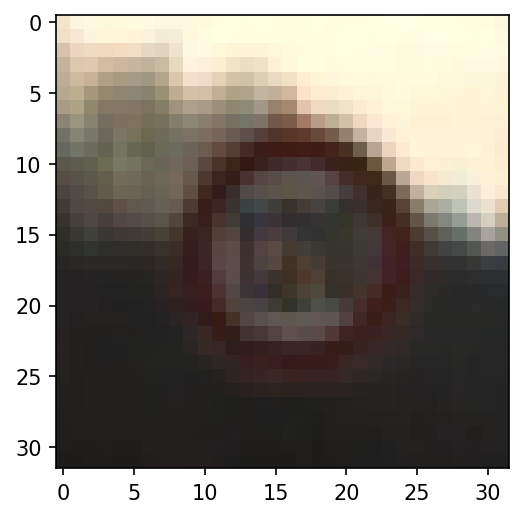

Limitation de vitesse (120km/h)


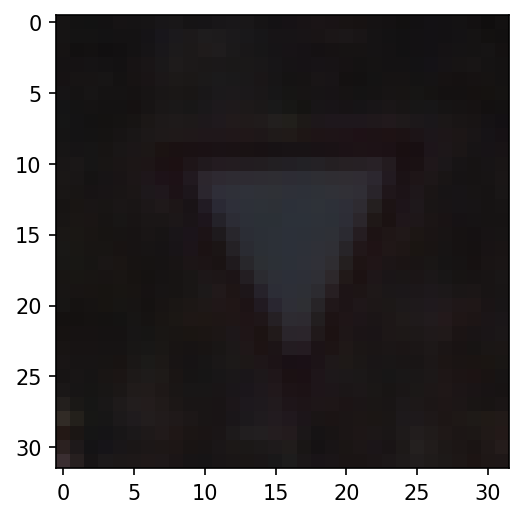

Ceder le passage


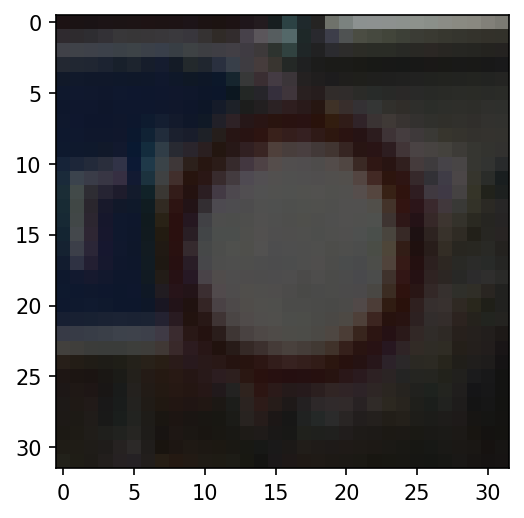

Circulation interdite


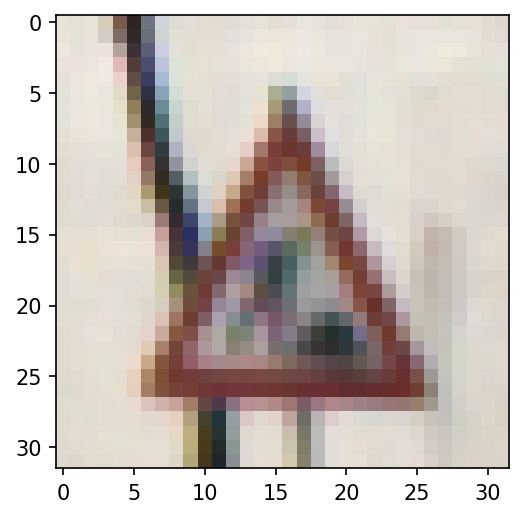

Travaux en cours


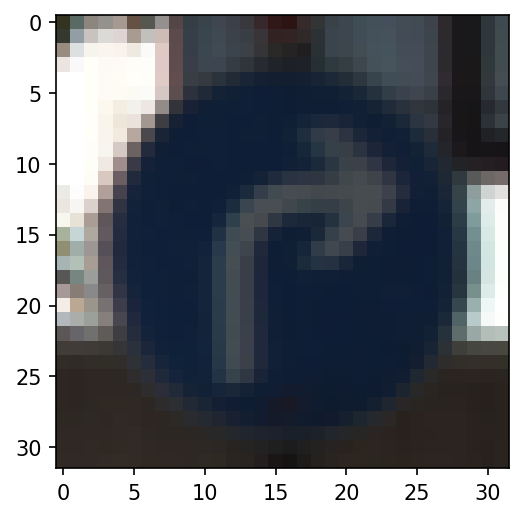

Direction obligatoire a' la prochaine intersection : a' droite


In [10]:
for images, labels in train_loader :
    for i in range(5) :
        plt.imshow(images[i].permute(1,2,0))
        plt.show()
        print(CLASSES[int(raw_data.classes[labels[i]])]) # pour palier au probleme d'ordre des classes voici ce que nous devons faire
    break

Regardons maintenant la repartition des données, en commençant par les raw_data.

In [43]:
def repartition(dico, d, total) :
    for image, label in d :
        if raw_data.classes[label] in dico :
            dico[raw_data.classes[label]] += 1
        else :
            dico[raw_data.classes[label]] = 1
        total += 1

    for key in dico :
        dico[key] = 100*(dico[key] / total)

    my_list = dico.items()
    my_list = sorted(my_list)
    x, y = zip(*my_list)

    import plotly.graph_objects as go
    fig = go.Figure(
        data=[go.Bar(x=x, y=y)],
        layout_title_text="Nombre d'images par classe (en %)",
        layout_width=1000,
        layout_height=500
    )
    fig.show()
    return x, y

In [44]:
raw_count = {}
raw_total = 0

x_r, y_r = repartition(raw_count, raw_data, raw_total)

Continuons avec la repartition dans le training et la validation.

In [46]:
train_count = {}
train_total = 0

valid_count = {}
valid_total = 0

for image, label in train_dataset :
    if raw_data.classes[label] in train_count :
        train_count[raw_data.classes[label]] += 1
    else :
        train_count[raw_data.classes[label]] = 1
    train_total += 1
for image, label in validation_dataset :
    if raw_data.classes[label] in valid_count :
        valid_count[raw_data.classes[label]] += 1
    else :
        valid_count[raw_data.classes[label]] = 1
    valid_total += 1

for key in train_count :
    train_count[key] = 100*(train_count[key] / train_total)
for key in valid_count :
    valid_count[key] = 100*(valid_count[key] / valid_total)

my_list_train = sorted(train_count.items())
my_list_valid = sorted(valid_count.items())
x_t, y_t = zip(*my_list_train)
x_v, y_v = zip(*my_list_valid)

import plotly.graph_objects as go
fig = go.Figure(
    data=[
        go.Bar(name='Training', x=x_t, y=y_t), 
        go.Bar(name='Validation', x=x_v, y=y_v),
        go.Bar(name='Raw', x=x_r, y=y_r)
    ],
    layout_title_text="Nombre d'images par classe (en %)",
    layout_width=1200,
    layout_height=500
)
fig.show()

Regardons la repartition du Test pour finir.

In [ ]:
test_count = {}
test_total = 0

x_s, y_s = repartition(t_count, raw_data, raw_total)